In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

In [2]:
plt.style.use('dark_background')
sns.set_palette("bright")

In [3]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', SVC(kernel='rbf', probability=True, C=1, gamma='auto'))
])

In [6]:
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


In [7]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

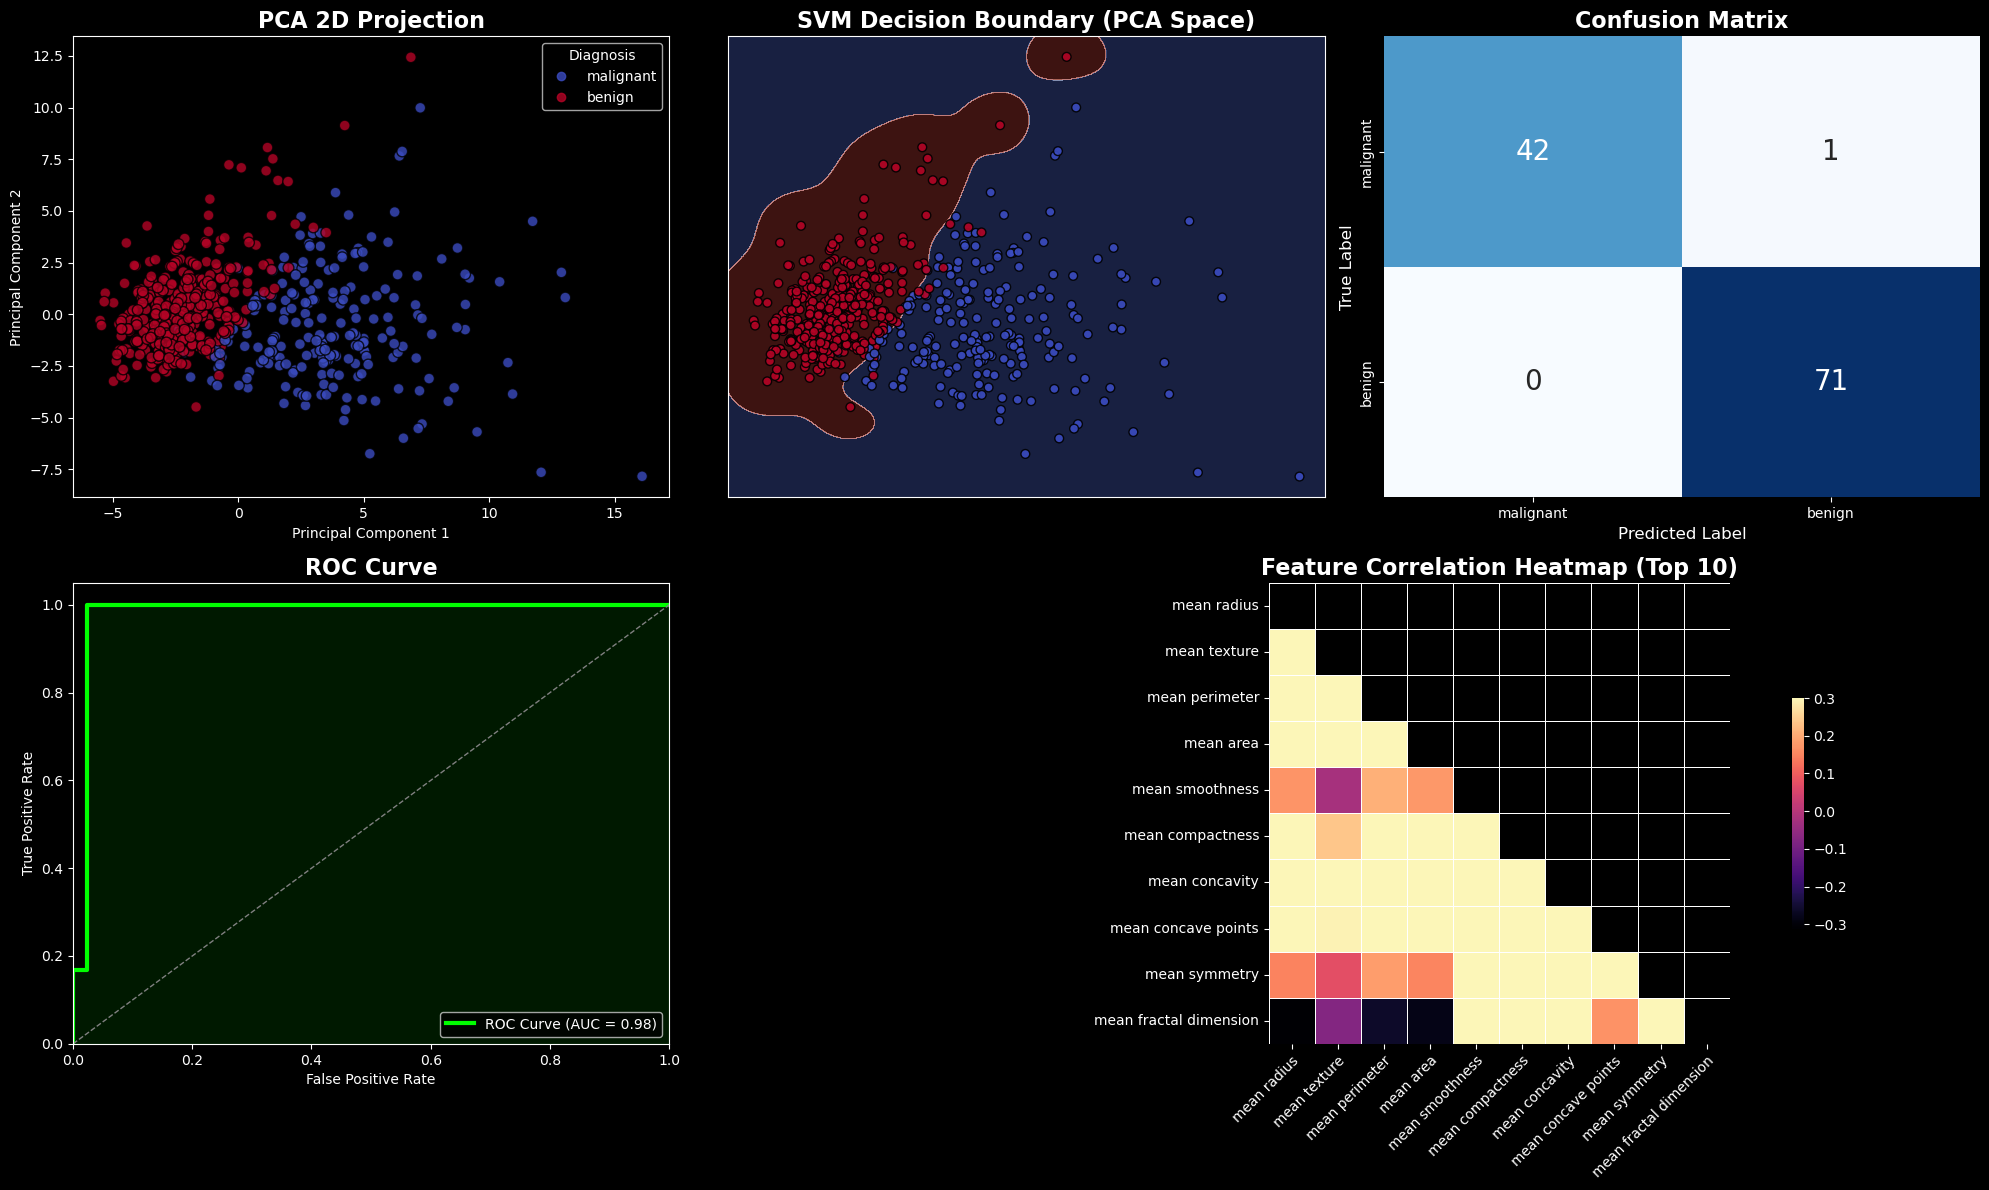

              precision    recall  f1-score   support

   malignant       1.00      0.98      0.99        43
      benign       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [22]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
X_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['scaler'].transform(X))
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=60, alpha=0.8)
ax1.set_title('PCA 2D Projection', fontsize=16, fontweight='bold', color='white')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
legend1 = ax1.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Diagnosis")
plt.setp(legend1.get_title(), color='white')
plt.setp(legend1.get_texts(), color='white')

ax2 = fig.add_subplot(gs[0, 1])
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = pipeline.named_steps['classifier'].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax2.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=40, alpha=0.9)
ax2.set_title('SVM Decision Boundary (PCA Space)', fontsize=16, fontweight='bold', color='white')
ax2.set_xticks(())
ax2.set_yticks(())

ax3 = fig.add_subplot(gs[0, 2])
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False, annot_kws={"size": 20})
ax3.set_title('Confusion Matrix', fontsize=16, fontweight='bold', color='white')
ax3.set_xlabel('Predicted Label', fontsize=12)
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_xticklabels(target_names)
ax3.set_yticklabels(target_names)


ax4 = fig.add_subplot(gs[1, 0])
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax4.plot(fpr, tpr, color='#00ff00', lw=3, label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax4.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve', fontsize=16, fontweight='bold', color='white')
legend4 = ax4.legend(loc="lower right")
plt.setp(legend4.get_texts(), color='white')
ax4.fill_between(fpr, tpr, alpha=0.1, color='#00ff00')

ax5 = fig.add_subplot(gs[1, 1:])
df_corr = pd.DataFrame(data.data, columns=data.feature_names)
corr = df_corr.iloc[:, :10].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='magma', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax5)
ax5.set_title('Feature Correlation Heatmap (Top 10)', fontsize=16, fontweight='bold', color='white')
plt.setp(ax5.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred, target_names=target_names))